# RL homework 3

-------------------------------


**Name:** Your Name

**SN:** Your Student Number

-----------------------------------


**Due date:** *May 13, 2020, 11:00 am*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will implement several algorithms to investigate the role of planning in reinforcement learning.

#### Part 2:
You will be guided through the implementation of a full deep reinforcement learning agent.

#### Part 3:
You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.



# Setup

Run all the cells in this section, but do not modify them.

## Imports

In [0]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [0]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


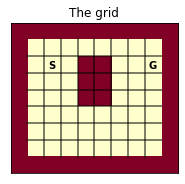


An alternative grid world


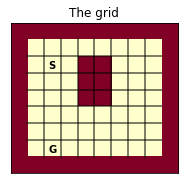


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


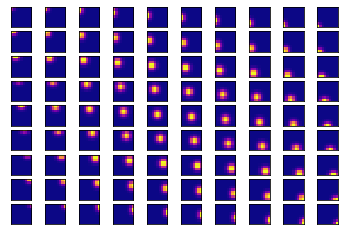

In [0]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [0]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Planning [50 marks]

## 1.1: Implement Models

### Question 1.1.1
**[3 pts]** 

Implement a trainable **tabular model** of the environment.

The model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

Given that the environment is deterministic and tabular the model will reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.S = np.zeros((number_of_states, number_of_actions), dtype='int8')
    self.R = np.zeros((number_of_states, number_of_actions), dtype='float32')
    self.G = np.zeros((number_of_states, number_of_actions), dtype='float32')

  def next_state(self, s, a):
      return self.S[s,a]
  
  def reward(self, s, a):
    return self.R[s,a]

  def discount(self, s, a):
    return self.G[s,a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.R[state, action] = reward
    self.S[state, action] = next_state
    self.G[state, action] = discount

### Question 1.1.2

**[5 pts]** 

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by stochastic gradient descent. 

Write down the update to the parameters of the models and implement the update in the model below.


In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.M = np.zeros((number_of_actions, number_of_features, number_of_features), dtype = 'float32')
    self.mr = np.zeros((number_of_actions, number_of_features,), dtype = 'float32')
    self.mg = np.zeros((number_of_actions, number_of_features,), dtype = 'float32')

  def next_state(self, s, a):
    next_state = np.matmul(self.M[a, :, :], s)
    return next_state
  
  def reward(self, s, a):
    R = np.dot(self.mr[a, :], s)
    return R

  def discount(self, s, a):
    gamma =  np.dot(self.mg[a, :], s)
    return gamma

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self.M[action, :, :] += step_size * np.matmul((next_state - self.next_state(state, action)).reshape(-1,1) , state.reshape(1,-1))
    self.mr[action, :] += step_size * (reward - self.reward(state, action)) * state
    self.mg[action, :] += step_size * (discount - self.discount(state, action)) * state

## 1.2: Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents you implement in this section must share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode of the agent's lifetime.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Question 1.2.1

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate each observed transition *(s, a, r, s')* in a *replay buffer*,
* apply an online Q-learning update with the most recently observed transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._state = initial_state
    self._action = np.random.randint(number_of_actions) # choose a random action to initalise
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    self.ReplayBuffer =[]
    self.number_of_actions = number_of_actions
    self.Q = np.zeros((number_of_states, number_of_actions), dtype='float32') # initalise all q_values to zeros?

  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    # Append to ReplayBuffer
    self.ReplayBuffer.append([s, a, r, g, next_s])
    self.Q[s, a] += self._step_size * (r + g* np.max(self.Q[next_state, :]) - self.Q[s,a])
    

    # Sample Experiences and perform offline updates
    index = np.random.randint(len(self.ReplayBuffer), size = self._updates) 
    for i in range(self._updates):
      s_re, a_re, r_re, g_re, next_s_re = self.ReplayBuffer[index[i]]
      self.Q[s_re,a_re] += self._step_size * (r_re + g_re * np.max(self.Q[next_s_re]) - self.Q[s_re,a_re])

    # Choose new actions
    self._action = self._behaviour_policy(self.Q[next_s])
    self._state = next_s

    return self._action



### Question 1.2.2

**[5 pts]**

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._state = initial_state
    self._action = np.random.randint(number_of_actions) 
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    self.number_of_actions = number_of_actions
    self.Q = np.zeros((number_of_states, number_of_actions), dtype='float32') 
    self.ReplayBuffer = []
    self.model = TabularModel(number_of_states, number_of_actions)

    
  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    self.ReplayBuffer.append([s, a])
    self.Q[s, a] += self._step_size * (r + g* np.max(self.Q[next_state, :]) - self.Q[s,a])

    # Update model
    self.model.update(s, a, r, g, next_s)

    # Planning
    index = np.random.randint(len(self.ReplayBuffer), size = self._updates) 
    for i in range(self._updates):

      # Sample
      s_re, a_re = self.ReplayBuffer[index[i]]

      # Generate from Model
      r_M, g_M, next_s_M = self.model.transition(s_re, a_re)

      # Offline update
      self.Q[s_re, a_re] += self._step_size * (r_M + g_M * np.max(self.Q[next_s_M, :]) - self.Q[s_re,a_re])


    # Choose new actions
    self._state = next_s
    self._action = self._behaviour_policy(self.Q[next_s])

    return self._action

### Question 1.2.3

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.  The observed `state` will now be a vector of length `number_of_features`, and the value estimate will be $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [0]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._number_of_features = number_of_features
    self._number_of_actions = number_of_actions
    self._M = np.zeros((number_of_actions,number_of_features),'float32')


  def q(self, state):
    return np.matmul(self._M, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    # Append to ReplayBuffer
    self.ReplayBuffer.append([s, a, r, g, next_s])
    
    # Learn the weights 
    self._M[a,:] += self._step_size * (r + g * np.max((self._M @ next_s)) - (self._M @ s)[a]) * s
    
    # Sample Experiences and perform offline updates
    index = np.random.randint(len(self.ReplayBuffer), size = self._updates) 
    for i in range(self._updates):
      s_re, a_re, r_re, g_re, next_s_re = self.ReplayBuffer[index[i]]
      self._M[a_re,:] += self._step_size * (r_re + g_re * np.max((self._M @ next_s_re)) - (self._M @ s_re)[a_re]) * s_re
    
    # Choose new actions
    self._action = self._behaviour_policy(self.q(next_s))
    self._state = next_s

    return self._action

### Question 1.2.4

**[5 pts]**

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [0]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._number_of_features = number_of_features
    self._number_of_actions = number_of_actions
    self._M = np.zeros((number_of_actions,number_of_features),'float32')
    self.model = LinearModel(number_of_features, number_of_actions)

  def q(self, state):
    return self._M @ state

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    self.ReplayBuffer.append([s, a])
    
     # Learn the weights 
    self._M[a,:] += self._step_size * (r + g * np.max((self._M @ next_s)) - (self._M @ s)[a]) * s
    
    # Update model
    self.model.update(s, a, r, g, next_s, step_size = self._step_size)

    # Planning
    index = np.random.randint(len(self.ReplayBuffer), size = self._updates) 
    for i in range(self._updates):

      # Sample
      s_re, a_re = self.ReplayBuffer[index[i]]

      # Generate from Model
      r_M, g_M, next_s_M = self.model.transition(s_re, a_re)

      # Offline update
      self._M[a_re,:] += self._step_size * (r_M + g_M * np.max((self._M @ next_s_M)) - (self._M @ s_re)[a_re]) * s_re
    
    # Choose new actions
    self._state = next_s
    self._action = self._behaviour_policy(self.q(next_s))

    return self._action



## 1.3: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

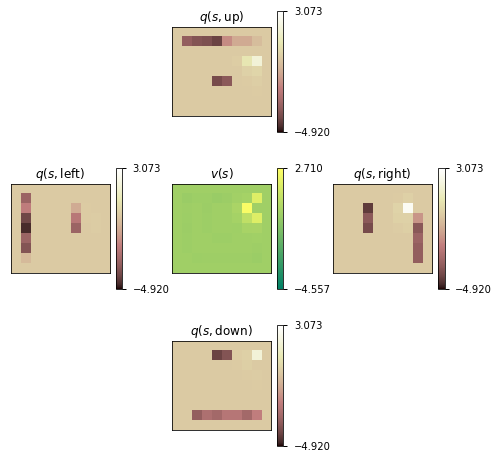

In [0]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

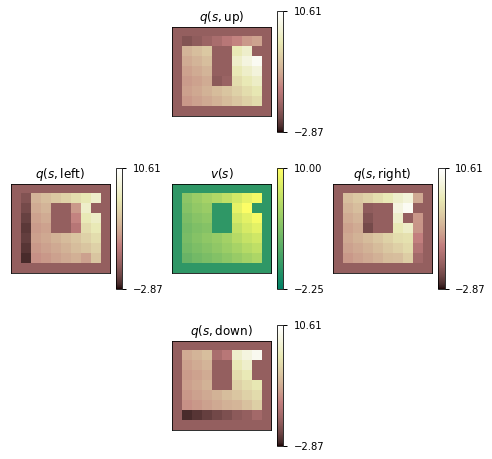

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

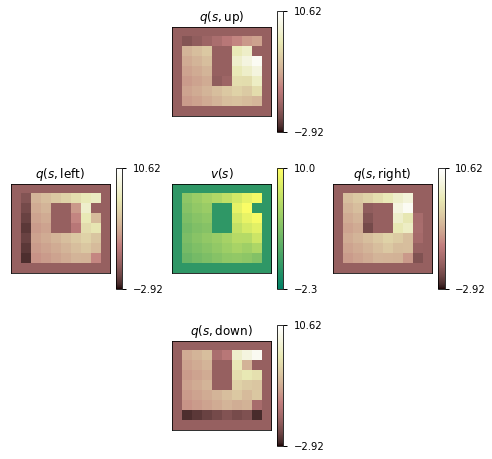

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 1.3.1

**[3 pts]**

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.


> - Comparing Online Q-learning with DynaQ and Experience Replay: The value estimates computed by the online Q-learning agent are still far from converging, as even the values of states along the edge as stochastic, as opposed to eg. the values estimates along the bottom of the grid for both experience replay and dyna-Q, with the values increasing from left to right. The agents making use of offline updates ie. ExperienceReplay and Dyna Q agents make a significantly more efficient use of the data as each step of experience could be used many times in value function updates - this is especially useful in cases where sampling from real experience is costly. Although all 3 agents have access to the same amount of data, online Q-learning only learns distinctive  q-values for the states right next to the edges and for the states adjacent to the goal, while assigning equivalent q-values to all the intermediate states, meanwhile the q-values for ExperienceReplay and DynaQ converge faster due to multiple passes throught the data. This is because Online Q-learning only makes 2k updates, while the planning models make 60k updates, thus making a much more efficient use of the data available.

> - While there are many similarities between experience replay and Dyna-Q in the tabular setting, there are some differences (dyna-Q is fully converged, Experience Replay is nearly converged) due to the fact that experience replay is model-free, while Dyna-Q is model-based: in experience replay, we uniformly sample random full transitions from the entire history of the agent, while in Dyna-Q in the tabular setting we sample the state-action pair randomly while  the reward and next state correspond to the last experiences reward and next state observed for this (s,a) pair. Thus, for Dyna-Q we always use most recent experience, while Experience Replay samples uniformly from the entire trajectory thus seen.

>- We assume that all of the samples are iid, but that is usually not the case, as the updates are all time-correlated with each other. It is worthwhile to note that in offline updates the samples are randomized and this decorrelated the updates, thus making this assumption more plausible and reducing variance of the updates, as opposed to standard Q-learning.

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

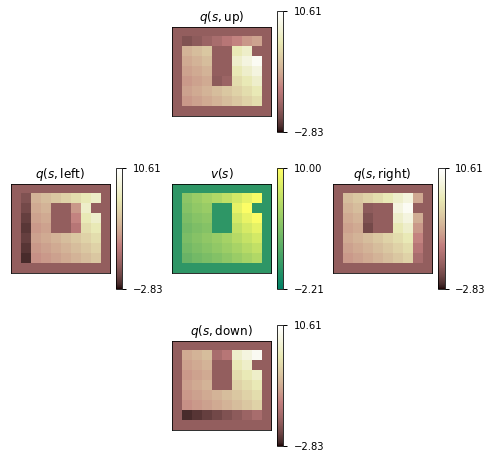

In [0]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

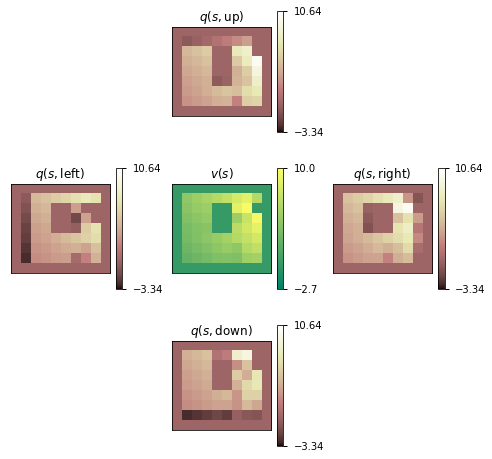

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

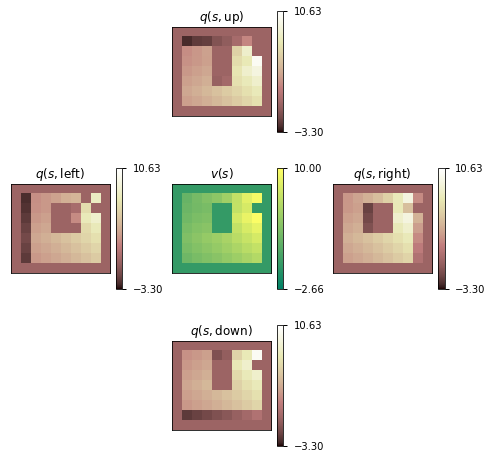

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above are the same as those above question 1.3.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

### Question 1.3.2

**[3 pts]**

How do the learnt values, and the relative performances, change, compared to the experiment above question 1.3.1?  Explain in at most 5 sentences.


>- Using the same number of steps, we see that the value estimates learnt by the Online Q-Learning has converged, whereas both agents which make offline updates have still not converged.
- This is because in Online Q-learning with each step we recieve new information, whereas the experience replay and Dyna-Q agents re-use some of older experiences. In the case of experience replay, as we are sampling entire transitions, this may lead to a bias. And even in the case of Dyna-Q we can expect some bias in the initial stages as planning is restricted only to the limited experience was thus leading to some bias and hence learning a sub-optimal policy in the limited number of steps.
- Hence, we can conclude that when sampling from the environment is cheap and we are only concerned with the amount of computation, rather than with data efficiency, in that case learning from the environment is much more efficient and thus preferred. 
- However, when it is expensive to sample from experience and we are concerned with data efficiency then planning can still be very useful: here, as in the previous question, we see that Dyna-Q outperforms Experience Replay. This is due to bias which arises in Experience Replay as a result of sampling entire transitions. 

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

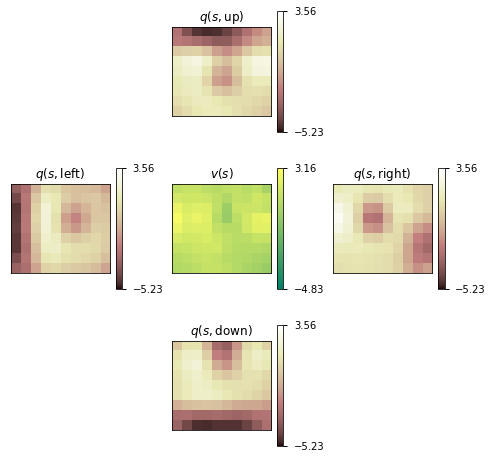

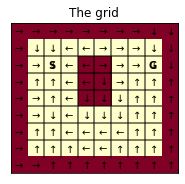

In [0]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

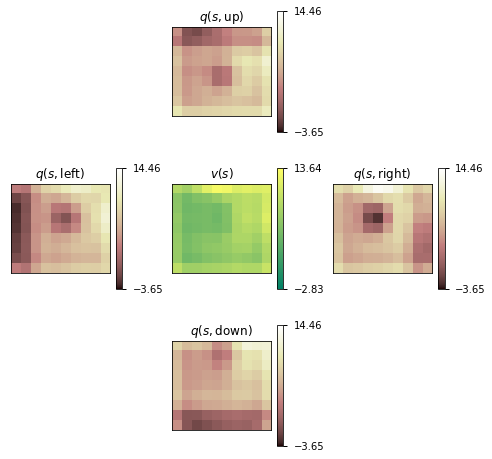

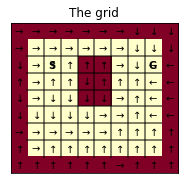

In [0]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

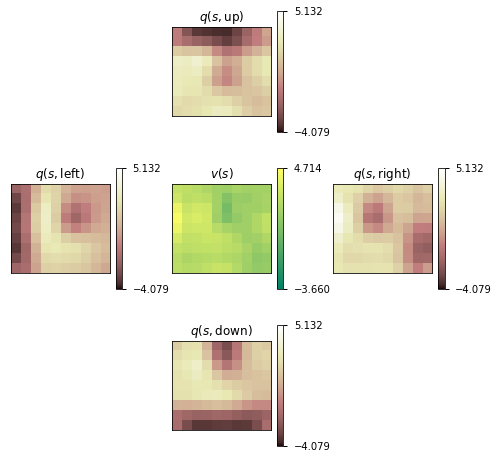

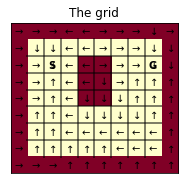

In [0]:
# DynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Question 1.3.3

**[3 pts]**

How do the value estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 2.2.1?

Explain the results in at most 5 sentences.

> - When using function approximation, we find that the value estimates are a lot more continuous and `blurry', despite many more training steps and interactions with the environment - this is because in function approximation, when performing an update for a single state, we update the weights which in turn means that we update our values for all of the states. Meanwhile in the tabular setting, when updating a single q(s,a) value, all the others are unaffected, we only update the target for other q-values. Thus here, the values of states adjacent to each other tend to be much more similar and change gradually.
- Moreover, interestingly enough in tabular learning we do not make any estimates for the walls, since we never encounter them. However with value function approximation we also create estimates for those states. 
- In general, we can see that here the value estimates for all 3 of the agents are poorer when using function approximation than when using tabular learning: we can assume that this is the case since the number of states here is relatively small and we can easily explore all of them and learn in a tabular way, thus making fewer approximations. However, if we were in a significantly larger state-space, we would expect value function to have a marked advantage over tabular learning.
- We notice, somewhat surprisingly, that the online q-learning and dyna-q have surpsingly high value estimates around the start state.

### Question 1.3.4

**[3 pts]**

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

> - We note that none of the 3 algorithms have converged to the optimum policy, despite a lot more training steps and interactions with the environment.
- In the policies, we observe a lot of random inconsistencies, for instace we notice that all 3 agents have developed a preference for heading towards the Start state in its proximity. This is somewhat surprising, but perhaps can be justified when we consider that there are no explicit updates for the start state, hence its value can be seen as '0', while the values of the neighbouring states become negative can the agent encouters walls etc. We also notice that at times arrows in adjacent states point at each other, which would cause the agent to get stuck and able to escape only using the $\epsilon$-greedy random action. Also, we notice that some of the states adjacent to the goal do not point to it.
- All of these inconsistencies arise due to the fact that we are using linear function approximation and thus the values of states are computed via generalising, thus there is a loss of accuracy.
- As mentioned above, the tabular agents perform much better, given the deterministic nature of the environment and very small state-space, but we would expect to observe the benefits of function approximation in an environment that is more stochastic and with a large number of states.
- An important consideration here is the fact Linear Dyna-Q uses a linear model thus it can in fact learn an incorrect model by failing to correctly generalise, in which case it would be likely to learn a suboptimal policy. Meanwhile Experience Replay uses real experiences for offline updates thus it is not exposed to the threat of using an incorrect model to simulate experiences. In other words, Linear Dyna-Q attempts to learn and approximate the Markov Decision Process, and subsequently sample from it, while Experience Replay uses samples from the true MDP. Thus we would expect Experience Replay to eventually converge to the optimum policy, but we cannot guarantee what this would also happen with Linear Dyna-Q.

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

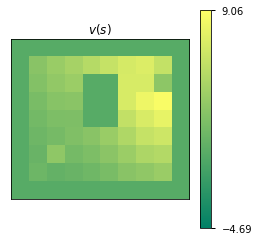

In [0]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

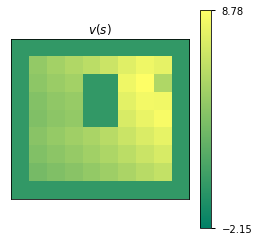

In [0]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

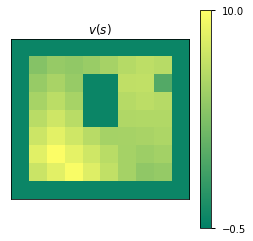

In [0]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Question 1.3.5

**[5 pts]**

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> - Online Q-learning has just started to notice that there has been a change in values - a single square in bottom left corner is now slightly higher in value, however it will take it still many iterations to learn the new value estimates for the entire grid.
- Meanwhile Dyna-Q, using the same amount of experience, has assigned lower value estimates to the top right and higher to bottom left. This indiates that it has fully learnt the new location of the goal and updated the values of the entire grid. This is because Dyna-Q makes more efficient use of the data available using planning: it is re-using the most recent experience multiple times to make to updates thus the changes in value estimates are reinforced and learned much faster. 


### Question 1.3.6

**[5 pts]**

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location, explain what you see.

> - Experience replay continues to assign high values to top right of the grid and low values to bottom left of the grid. Thus, it still has not learned the new values and is far from doing so.
- One of the reasons for this is in that experience replay uses full transitions, which stretch back through the entire history of the agent. There is no priority given to the transitions which have occured more recently, hence updates are made using old data, which was sampled from experience before the goal location changed.
- Here we are using the tabular model for DynaQ hence the offline updates for a randomly selected (s,a) using DynaQ correspond to the most recently seen reward and next state for this (s,a). This allows for better reaction to change and enables the agent to learn much quicker. In DynaQ we always use the most recent experience to update, which is not the case with Experience Replay.


# Part 2: Deep RL [25 marks]

### Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [1]:
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/
!pip install dm-haiku

Cloning into 'bsuite'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (878/878), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 1362 (delta 628), reused 683 (delta 462), pack-reused 484
Receiving objects: 100% (1362/1362), 681.06 KiB | 10.01 MiB/s, done.
Resolving deltas: 100% (949/949), done.
Processing ./bsuite
     |████████████████████████████████| 296kB 5.4MB/s 
  Created wheel for bsuite: filename=bsuite-0.0.0-cp36-none-any.whl size=245994 sha256=2c6cc0d60fcf4fa794a36db30d324e07f8c0fdc457e15a263083907f341f39fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3mw3ze_/wheels/a8/39/ce/aa00d5f213ee4ff8bb4faf9d6ff36b510dd9ecd0faa819baa1
  Created wheel for frozendict: filename=frozendict-1.2-cp36-none-any.whl size=3149 sha256=5cfe1664fc381886edb44dd7128868c086ac32825f357e7b6f2ad8a07a0eb97b
  Stored in directory: /root/.cache/pip/wheels/6c/6c/e9/534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built bsuite frozendict
  

### Imports

In [0]:
from bsuite.experiments.catch import catch

import jax
import jax.numpy as jnp
import haiku as hk

import numpy as np
import matplotlib.pyplot as plt

### Neural networks

You will now use JAX to define a network parametrising:

* The values of each state $v_{\pi}(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions (`init_net`, and `apply_net`):

The `init` function has signature `parameters = init_net(key, obs)`. 
  * takes a `jax.random.PRNGKey` and an `observation`
  * returns randomly sampled weights for the neural network.

The `apply_net` functions have signature `v, p = apply_net(parameters, obs)` 
  * takes the current set of `parameters` and an `observation`
  * returns a scalar value `v` and a vector of preferences `p`

### Q 3.1 [5 marks]

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = Relu(W.dot(flat_obs) + b)`
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden layer should have 50 units
* the action preferences should be a vector of 3 elements (one per each available action),
* the value should be a scalar (not a vector with one element).


In [0]:
def forward_pass(observation):
  flatten_fnc = lambda x: jnp.reshape(x, (-1,))
  network = hk.Sequential([
      flatten_fnc,
      hk.Linear(50),
      jax.nn.relu, 
  ])
  h = network(observation)
  action_preferences = hk.Linear(3)(h)
  state_value =  hk.Linear(1)(h)
  state_value = jnp.squeeze(state_value, axis = -1)

  return state_value, action_preferences


init_net, apply_net = hk.transform(forward_pass)

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q 3.2 [5 marks]

Implement a softmax policy parametrised by the neural network above.

The function has signature `action = policy(net_params, key, obs)`,
* Taking the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Returning an `action` sampled from a softmax distribution (with temperature 1.) over the set of preferences output by the neural network.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you will therefore need to use the `split` function to generate a new random key before every new sampling. The run loop that runs the experiment later on takes care of this for you: you can assume that a new random `key` is provided to you on each call to the `policy`, and you do not need to split the key yourself within the function.



In [0]:
@jax.jit
def policy(net_params, key, obs):
  """Sample action from a softmax policy."""
  v, p = apply_net(net_params, obs)
  a = jax.random.categorical(key, p)

  return a

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q 3.3 [5 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

The function must have signature `grads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `grads` has the same structure as `net_params`
  * as it contains an estimate of the gradient of the expected episodic return wrt to each parameter 

In [0]:
def policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):

  def log_policy(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    v_tm1, p_tm1 = apply_net(net_params, obs_tm1)
    v_t, p_t = apply_net(net_params, obs_t)
    return jax.lax.stop_gradient(r_t + discount_t * v_t - v_tm1) * jax.numpy.log(jax.nn.softmax(p_tm1)[a_tm1])

  policy_grad = jax.grad(log_policy)(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)

  return policy_grad


### Q 3.4 [5 marks]

Implement a function to compute a stochastic estimate of the negative gradient of the value loss:   $ L(\theta) = E_{s \sim \pi}[(v_{\theta}(s) - v_{\pi}(s))^2]$

As for the policy gradient, this must be computed from a 1 step transition in the environment, so using bootstrapping after one step.

It must have signature `neg_grads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `neg_grads` has the same structure as `net_params`
  * as it contains a stochastic estimate of the negative gradient of the expected value prediction loss 

In [0]:
def neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):

  def loss_comp(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    v_tm1, p_tm1 = apply_net(net_params, obs_tm1)
    v_t, p_t = apply_net(net_params, obs_t)

    loss = -0.5 * (v_tm1 - jax.lax.stop_gradient(r_t + discount_t * v_t)) ** 2
    
    return loss

  neg_g = jax.grad(loss_comp)
  neg_grad = neg_g(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)

  return neg_grad

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The negative gradient of the value loss identifies the direction of change in the parameters that most steeply improves the value predictions.

However, note that the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we will simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.

In [0]:
@jax.jit
def compute_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are typically rescaled to avoid taking too large a step on a single update.
For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by, rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$


### Q 3.5 [5 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
* See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for references.

This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \eta) g + \eta \mu$ where $g$ is the latest stochastic gradient.
* Update the second moment of each gradient component $\nu_i = (1 - \eta) g_i ^ 2 + \eta \nu_i $ where $g$ is the latest gradient update.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_1 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

In the next cell define a pair of functions (`opt_init`, and `opt_update`), where:

The `opt_init` function has signature `state = opt_init(params)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, state = opt_update(grads, state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

Set the algorrithm's hyper-parameters to:
* $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=1e-8$.

In [0]:

def adam(alpha = 3e-3, b1 = 0.9, b2 = 0.999, eps = 1e-8):
    
    def opt_init(params):
      state = {}
      state['b1'] = b1
      state['b2'] = b2
      state['e'] = eps
      state['alpha'] = alpha
      state['m'] = jax.tree_multimap(jax.np.zeros_like, params)
      state['v'] = jax.tree_multimap(jax.np.zeros_like, params)
      state['k'] = 0 
      return state

    def opt_update(grads, state):       
      state['k'] += 1

      # load states
      b1 = state['b1']
      b2 = state['b2']
      e = state['e']
      m = state['m'] 
      v = state['v']
      alpha = state['alpha'] 
      k = state['k']

      # compute updates
      m = jax.tree_multimap(lambda m, g: (1 - b1) * g + b1 * m, m, grads)
      v = jax.tree_multimap(lambda m, g: (1 - b2) * (g ** 2) + b2 * m, v, grads)
      numerator = jax.tree_multimap(lambda mu: mu / (1 - b1 ** k), m)
      denominator = jax.tree_map(lambda nu: e + jnp.sqrt(nu / (1 - b2 ** k)), v)
      updates = jax.tree_multimap(lambda num, denom: alpha * num / denom, numerator, denominator)

      # update the states
      state['m'] = m 
      state['v'] = v

      return updates, state
    
    return opt_init, opt_update

opt_init, opt_update = adam(3e-3, b1 = 0.9, b2 = 0.999, eps = 1e-8)


### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on seubsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

In [0]:
from bsuite.environments import catch
from jax.experimental import optix

In [69]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = hk.PRNGSequence(jax.random.PRNGKey(42))
sample_input = env.observation_spec().generate_value()
net_params = init_net(next(rng), sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(optix.apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  a_tm1 = policy(net_params, next(rng), obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    a_t = policy(net_params, next(rng), new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    dJ_dtheta = compute_gradient(
        net_params, obs_tm1, a_tm1, r_t, discount_t, new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

Training agent for 1500 episodes...


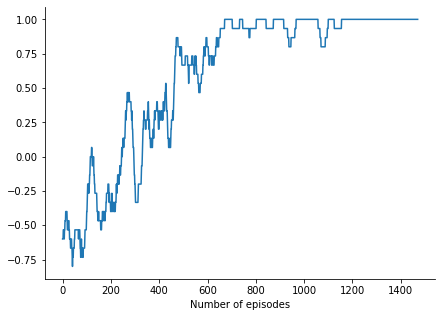

In [70]:
plt.figure(figsize=(7, 5))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smoothed_returns = moving_average(all_episode_returns, 30)
plt.plot(smoothed_returns)

plt.xlabel('Average episode returns')
plt.xlabel('Number of episodes')

ax = plt.gca()
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Part 3: Off-policy multi-step learning [25 marks]

For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necesary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 4.1 [15 marks]
Implement the return functions below and run the cells below that.

In [0]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rhos = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):

    pis = np.prod(pi[t:])
    mus = np.prod(mu[t:])
    rho = pis/mus
    rhos[t] = rho
    
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t] * ((1 - l)*v[t + 1] + l*G[t + 1]) 
    
  G = np.multiply(G, rhos )
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G



def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    rho = pi[t]/mu[t]
    
    if t == T - 1:
      G[t] = rho * (r[t] + d[t] * v[t + 1])
    else:
      G[t] = rho * (r[t] + d[t] * ((1 - l)*v[t + 1] + l*G[t + 1]))

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  
  return (1 - l)*v + l*G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.

  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho = pi[t]/mu[t]
    error = rho*(r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error)
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """

  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.

  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho = pi[t]/mu[t]
    l_t = min(1, 1/rho)
    error = l_t * rho * (r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error)
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns

  return v + l*errors

In [0]:

#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state
  # in this case, observations are just the real states
  observations = states
  # generate rewards
  rewards = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
  # compute discounts
  discounts = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0
  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 19.9528968  600.74725561 183.50067599   5.97789382   0.77094649]


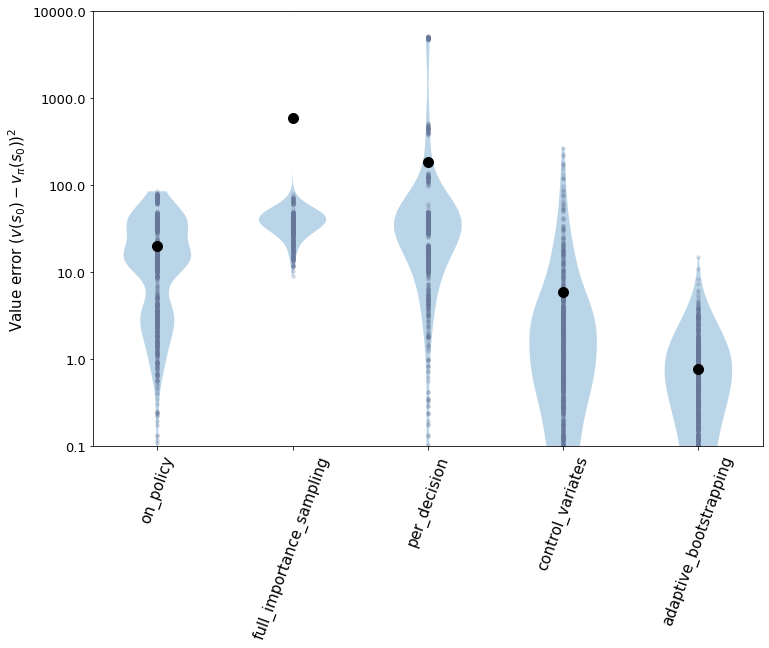

In [0]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision',
        'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 4.2 [5 marks]
Explain the ranking in terms of value error of the different return estimates.

> Ranking the algorithms according to their mean squared value error, from best to worst, we have:
1. Adaptive Bootstrapping
2. Control Variates
3. On Policy
4. Per Decision
5. Full importance sampling

> Adaptive Bootstrapping achieves the lowest mean squared value error, thus it is the best, while full importance sampling has the highest mean squared error, thus it peforms worst. 

> The mean squared error is the second moment of the error hence it encompasses both, the variance and the bias of the estimator. It is worth noticing that for an unbiased estimator MSE becomes just a measure of variance. 

> In general the estimates obtained using off-policy algorithms, eg. Per Decision, Full Importance Sampling etc. tend to have higher variance than those obtained on-policy - this is because in off-policy the data obtained using a behaviour policy is used to obtain value estimated for some target policy.

> However, we do notice that for the reduction in variance is possible for off-policy methods - it is achieved by introducing further variance-reducing techniques with each algorithm, which build on top of each other, thus leading to a constant decrease in variance. In fact, we could even say that each of the off-policy techniques generalises the one which comes before it in the ranking.

> Full importance sampling suffers from the highest mean squared error (denoted using a black dot). The very high mean is the caused by few extreme outliers, ie. events which are considered to be rare by the importance ratio. Thus, just as expected, importance sampling suffers from high variance. Mathematically, this is due to the fact that all the returns are weighted at the very end ie. we do not scale the returns which are used to compute the $G_t$. Meanwhile, Per-Decision achieves slightly lower variance since we start applying the weight $\rho_t$ to every reward, utilising the fact that earlier rewards cannot depend on later decisions - this allows us to eliminate some of the unnecessary weighting terms and thus reduce variance.

> Control Variates builds on top of per-decision, also utilisig the per-decision correction but it also introduces the weighting term on the error term, not only on the reward term. In this way, we utilise the knowledge about errors in known quantities to reduce the error in the estimate of an unknown quantitity. Thus, the control variate can correlate with the target, and like the previous alogorithms it is an unbiased estimator, hence it further reduces the variance.

> Lastly, we observe that adaptive bootstrapping achieves lowest mean squared error - it does so by introducing an adaptive trace parameter $\lambda_t$, which controls the degree of boostrapping. For  $\lambda_t$ less than 1  we truncate the return ie. include fewer importance sampling ratios thus further reducing the variance.



### Q 4.3 [5 marks]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> - Using the above ranking, the best return is achieved when using adaptive bootstrapping, as it achieves the lowest value error.
> - Usually, given a significantly-large state space, we will be using function approximation. However, we then find ourselves using the combination of off-policy learning, function approximation and bootstrapping. This places us in the deadly triad ie. we face the possibility of divergence when combining these 3. We cannot escape from using function approximation when the state space is too large to learn using the tabular methods thus we need to generalise. Of course, even when using all 3 we are not guaranteed to diverge, but the likelihood of this possibility increases with increasing degree of bootstrapping.
> -  Here, the degree of bootstrapping is controlled by the trace decay parameter $\lambda_t$, which is  defined as $\lambda_t = min(1, \frac{1}{\rho_t})$. 
A $\lambda_t$ parameter of 1 corresponds to no bootstrapping, whereas a $\lambda_t <1$ corresponds to boostrapping.  $\lambda_t$ is large, ie. near 1, when $\rho_t$ is small, ie. when the probabilities of the current action is small under the target policy and large under the behaviour policy, and $\lambda_t$ is small when $\rho_t$ is large, ie. when the probabilities of the current action being taken is large under the target and and small under the behaviour policy. This ensures a large reduction in variance, as we would expect to have very large variance when the action taken is very likely under the target but very unlikely under the behaviour. However, in this case, ie. when $\lambda_t$ is very small, we boostrap a lot thus increase the changes of diverging and falling into the deadly triad. Thus,if we want to at all costs avoid the possibility of diverging, we could use another approach instead such as control variates, where we can manually set the parameter $\lambda$ to be sufficiently high at all times and thus ensure we are never boostrapping too much and reduce the risk of falling into the deadly triad. 
> - Moreover, it is worth noting that any use of boostrapping necessarily introduces a certain degree of bias, since we are boostrapping on estimates which are not yet perfect. Thus, the more we boostrap, we further reduce variance but we also lead to an increase in bias. Thus, when considering the bias-variance trade-off, we need to consider whether we want to boostrap at all and trade-off a reduction in variance for an increase in bias.

